In [1]:
import math
import bs4 as bs
import pickle
import requests
import pandas as pd
import tensorflow
import yfinance as yf
from pyxll import RTD
import numpy as np
import openpyxl
from sklearn.metrics import r2_score
from statistics import variance, stdev
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.tsa.stattools as ts
import statsmodels.api as stat
import scipy.stats as stats
import numpy as np
from hurst import compute_Hc, random_walk
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [2]:
def first_mat3(new_d, mean, curr_stat, upper_exit, lower_exit):
    newd = [x for x in new_d]
    req_val = []
    j= 0
    #print(newd)
    for j in newd:
        if curr_stat == 1:
            if j > mean:
                #print(newd.index(j))
                return newd.index(j)
            
            elif j < lower_exit:
                return newd.index(j)
            else:
                continue
        elif curr_stat == -1:
            if j < mean:
                #print(newd.index(j))
                return newd.index(j)
            elif j > upper_exit:
                return newd.index(j)
            else:
                continue
        else:
            continue
    return 0


In [3]:

profit = []
dates = [['2022-01-01', '2022-04-27']]#, ['2021-01-01', '2021-03-31'], ['2021-04-01', '2021-08-30'], ['2021-09-01', '2021-12-31'], ['2022-01-01', '2022-04-18']]
stocks_list = ["GOOGL", "AAPL"]#, "TSLA", "NVDA", "FB", "MSFT", "AMZN"]
#stocks_list = ["GOOG", "GOOGL"]
#stocks_list=['AAPL','ABNB','ADBE','ADI','ADP','ADSK','AEP','ALGN','AMAT']#,'AMD','AMGN','AMZN','ANSS','ASML','ATVI','AVGO','AZN','BIDU','BIIB','BKNG','CDNS','CEG','CHTR','CMCSA','COST','CPRT','CRWD','CSCO','CSX','CTAS','CTSH','DDOG','DLTR','DOCU','DXCM','EA','EBAY','EXC','FAST','FB','FISV','FTNT','GILD','GOOG','GOOGL','HON','IDXX','ILMN','INTC','INTU','ISRG','JD','KDP','KHC','KLAC','LCID','LRCX','LULU','MAR','MCHP','MDLZ','MELI','MNST','MRNA','MRVL','MSFT','MTCH','MU','NFLX','NTES','NVDA','NXPI','ODFL','OKTA','ORLY','PANW','PAYX','PCAR','PDD','PEP','PYPL','QCOM','REGN','ROST','SBUX','SGEN','SIRI','SNPS','SPLK','SWKS','TEAM','TMUS','TSLA','TXN','VRSK','VRSN','VRTX','WBA','WDAY','XEL', 'ZM', 'ZS']
for k in range(len(dates)):
    data = pd.DataFrame(columns = stocks_list)
    da =f'{dates[k][0]} {dates[k][1]}'
    for i in stocks_list:
        data1 = yf.download(tickers=i, start=dates[k][0], end=dates[k][1], interval='1h')
        data[i]= data1["Close"]


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
y = np.log(data/data.shift(1))
corr_mat = y.corr()
corr_mat

,GOOGL,AAPL
GOOGL,1.000000,0.690072
AAPL,0.690072,1.000000


In [5]:
corr_data = []
for m in range(len(stocks_list)):
    for n in range(m+1, len(stocks_list)):
        x = stocks_list[m]
        y = stocks_list[n]
#    for i in range(0, len(corr_mat.index)):
#        for j in range(i+1, len(corr_mat.columns)):
        if corr_mat[x][y] == 1:
            pass
        else:
            name = f'{x}_{y}'
            corr_data.append([name, corr_mat[x][y]])

In [6]:
pair = []
for i in corr_data:
    if i[1] > 0.5:
        pair.append(i)
    else:
        continue     
kkl = []
for i in pair:
    kkl.append(i[0])

In [7]:

time_range = [ x for x in (data.index)]
new_data=data.diff()
new_data.index = [x for x in range(0, len(new_data.index))]
new_data = new_data.drop(0)
df = pd.DataFrame()
for i in range(0, len(stocks_list)-1):
    for j in range(i+1, len(stocks_list)):
        check = f'{stocks_list[i]}_{stocks_list[j]}'
        if check in kkl :
            #print(check)
            x  = new_data[stocks_list[i]]
            y  = new_data[stocks_list[j]]
            y = y[:-1]
            x = x[:-1]
            x_reshaped = np.array(x).reshape((-1, 1))
            y_reshaped = np.array(y).reshape((-1, 1)) 
            result = stat.OLS(x_reshaped, y_reshaped).fit()
            a = ts.adfuller(result.resid)
            r_square = result.rsquared
            #print(f'the r square value of is {r_square}')
            #print(f'adfuller results {a}' )
            #print(f"pvalue of pair  {stocks_list[i]} {stocks_list[j]} {a[1]}")
            #coint_johansen(data, 0, 1)
            #b = coint_johansen(data, 0, 1)
            #print(f'johansen cointergration test result {b.lr1} {b.cvt} {b.evec}\n')
            spread = f'{stocks_list[i]}_{stocks_list[j]}_spread'
            Z_Score = f'{stocks_list[i]}_{stocks_list[j]}_Z_Score'
            position = f'{stocks_list[i]}_{stocks_list[j]}_position'
            #print(position)
            strat_return = f'{stocks_list[i]}_{stocks_list[j]}_strat_return'
            rolling_mean = f'{stocks_list[i]}_{stocks_list[j]}_rolling_mean'
            mean = f'{stocks_list[i]}_{stocks_list[j]}_mean'
            #print(a)
            #print(r_square)
            if r_square > 0:  
                #print(1)
                if a[1] <= 0.06:
                    #print(check)
                    #print(1)
                    #print(a[1], a[4])
                    m = result.params[0]
                    df[stocks_list[i]] = new_data[stocks_list[i]][:-1]
                    df[stocks_list[j]] = new_data[stocks_list[j]][:-1]
                    df[spread] =( y_reshaped - m * x_reshaped)
                    series_mean = df[spread].mean()
                    #print(series_mean)
                    ar = np.array(df[spread])
                    series = np.cumprod(df[spread])
                    halflife = np.round(-np.log(2)/result.params[0], 0)
                    ma = (-1)*halflife
                    df[rolling_mean] = df[spread].rolling(int(ma)).mean()
                    df[Z_Score] = stats.zscore(df[spread])
                    df[mean] = df[spread].mean()
                    upper_exit_bound1 = series_mean+3*ar.std()
                    #print(upper_exit_bound1)
                    lower_exit_bound1 = series_mean-3*ar.std()
                    lower_inner = series_mean-0.5*ar.std()
                    lower_outer = series_mean-2*ar.std()
                    upper_inner = series_mean+0.5*ar.std()
                    upper_outer = series_mean+2*ar.std()
                    df[position] = 0
                    df[position] = np.where((((df[spread] < df[mean])&(df[spread]<lower_inner)&(df[spread] > lower_outer))), 1 , df[position])
                    df[position] = np.where((((df[spread] > df[mean])&(df[spread]>upper_inner)&(df[spread] < upper_outer))), -1 ,  df[position])
                    df[position] = np.where((((df[spread] >  upper_exit_bound1)) | (df[spread] < lower_exit_bound1)), -2 ,  df[position])
                    
                    df[position] = df[position].ffill()
                    df[strat_return] = df[spread]*df[position].shift()
                    profit = df[position]
                    #print(upper_exit_bound1)

<AxesSubplot:>

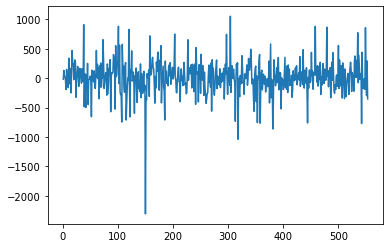

In [8]:
df["GOOGL_AAPL_spread"].plot()

In [9]:
print(time_range)

[Timestamp('2021-12-31 13:30:00-0500', tz='America/New_York'), Timestamp('2021-12-31 14:30:00-0500', tz='America/New_York'), Timestamp('2021-12-31 15:30:00-0500', tz='America/New_York'), Timestamp('2022-01-03 09:30:00-0500', tz='America/New_York'), Timestamp('2022-01-03 10:30:00-0500', tz='America/New_York'), Timestamp('2022-01-03 11:30:00-0500', tz='America/New_York'), Timestamp('2022-01-03 12:30:00-0500', tz='America/New_York'), Timestamp('2022-01-03 13:30:00-0500', tz='America/New_York'), Timestamp('2022-01-03 14:30:00-0500', tz='America/New_York'), Timestamp('2022-01-03 15:30:00-0500', tz='America/New_York'), Timestamp('2022-01-04 09:30:00-0500', tz='America/New_York'), Timestamp('2022-01-04 10:30:00-0500', tz='America/New_York'), Timestamp('2022-01-04 11:30:00-0500', tz='America/New_York'), Timestamp('2022-01-04 12:30:00-0500', tz='America/New_York'), Timestamp('2022-01-04 13:30:00-0500', tz='America/New_York'), Timestamp('2022-01-04 14:30:00-0500', tz='America/New_York'), Timesta

In [10]:
def avoid_repeatation(new_d, curr_stat):
    newd = [x for x in new_d]
    req_val = []
    #print(newd)
    j =1
    if curr_stat == 1:
        if -1 in newd:
            for j in range(0, len(newd)):
                if newd[j] == -1:
                    return j
                else:
                    continue
        else:
            return 2
    elif curr_stat == -1:
        if 1 in newd:
            for j in range(0, len(newd)):
                if newd[j] == 1:
                    return j
                else:
                    continue
        else:
            return 2
    else:
        return 0

In [11]:
def avoid_repeatation(new_d, curr_stat):
    newd = [x for x in new_d]
    req_val = []
    #print(newd)
    j =1
    if curr_stat == 1:
        if -1 in newd:
            for j in range(0, len(newd)):
                if newd[j] == -1:
                    return j
                else:
                    continue
        else:
            return 2
    elif curr_stat == -1:
        if 1 in newd:
            for j in range(0, len(newd)):
                if newd[j] == 1:
                    return j
                else:
                    continue
        else:
            return 2
    else:
        return 0

In [12]:
def datafr(df):
    aee = np.array(df)
    arr = []
    #print(aee[0:400])
    for i in range(0, len(aee)):
        curr_stat = aee[i]
        new_d = aee[i:len(aee)+1]
        #print(i, aee[i])
        k = 0
        k = int(avoid_repeatation(new_d, curr_stat))
        #arr.append(aee[i])
        if k == 2:
            m = len(new_d)-1
            #print(m)
            for j in range(i+1, i+m+1):
                aee[j] = 0
            aee[i+m] = (-1)*curr_stat
        else:
            m = k
            for j in range(i+1, i+m-1):
                aee[j] = 0
        if i != i+m:
            print(i,i+m, aee[i])#arr.append(0)                       
        #print(aee[0:400])
    #print(aee)
    return aee

In [13]:
for pb in range(0,len(stocks_list)):
    for pbb in range(pb+1, len(stocks_list)):
        name = f' {stocks_list[pb]} + {stocks_list[pbb]} '
        spread = f'{stocks_list[pb]}_{stocks_list[pbb]}_spread'
        Z_Score = f'{stocks_list[pb]}_{stocks_list[pbb]}_Z_Score'
        position = f'{stocks_list[pb]}_{stocks_list[pbb]}_position'    
        strat_return = f'{stocks_list[pb]}_{stocks_list[pbb]}_strat_return'
        rolling_mean = f'{stocks_list[pb]}_{stocks_list[pbb]}_rolling_mean'
        mean = f'{stocks_list[pb]}_{stocks_list[pbb]}_mean'
        profit = f'{stocks_list[pb]}_{stocks_list[pbb]}_ profit'
        #if position in df.columns:
        #    df[position] = datafr(df[position])

In [61]:
def cal_prof(curr_status, name, stack,ind, dff, curr_spread, spread, x, y, mm):
    val_X = x[0]
    val_Y = y[0]
    x = x[1:]
    y = y[1:]
    if m < 1:
        mm = 10*m
        nn = 10
    else:
        mm = round(m)
        nn = 1
    print(dff)
    #print(name)
    for i in range(0,len(dff)):
        #print(i, d)
        #print("here", dff[i], spread[i], curr_spread)
        if curr_status == 1:
            if stack[-1] != dff[i]:
                #print("buy", stack[-1], dff[i], curr_spread)
                next_spread = spread[i]
                if next_spread > lower_exit_bound1:
                    if next_spread > const_mean:
                        #stock_p = next_spread - curr_spread
                        stock_p = x[i] - m*y[i] - ( val_X - m*val_Y)
                        amount = nn*x[i] + mm*y[i]
                        unit = round(100000/amount)
                        print("m",curr_status,"stack", stack[-1], "next_stat", dff[i],"k", df[name][ind+i+1],"curr spread at", ind, "spread at", ind+i, df["GOOGL_AAPL_spread"][ind+i+1], curr_spread)
                        #print(ind, ind+i, df[name][ind], df[name][ind+1], df["GOOGL_AAPL_spread"][ind], df["GOOGL_AAPL_spread"][ind+i])
                        #amount = round(data[stocks_list[pb]][i]+round(m)*data[stocks_list[pbb]][i])
                        #unit = round(100000/amount)
                        profit33 = nn*stock_p*unit
                        #print(ind, ind+i, curr_status, dff[i])
                        #print("buy", )
                        #print("buy", profit33, unit, stock_p, i+k+1, next_spread, i, curr_spread)
                        #pnl3.append(profit33)
                        nepp.append([time_range[ind], time_range[ind+i+1], profit33])
                        return profit33
                    else:
                        continue
                else:
                    #stock_p = next_spread - curr_spread
                    print("n", curr_status,"stack", stack[-1], "next_stat", dff[i],"k", df[name][ind+i],"curr spread at", ind, "spread at", ind+i, df["GOOGL_AAPL_spread"][ind+i], curr_spread)
                        
                    stock_p = x[i] - m*y[i] - (val_X - m*val_Y)
                    amount = nn*x[i]+mm*y[i]
                    unit = round(100000/amount)
                    #print(ind, ind+i, df[name][ind], df[name][ind+1], df["GOOGL_AAPL_spread"][ind], df["GOOGL_AAPL_spread"][ind+i])
                    #amount = round(data[stocks_list[pb]][i]+round(m)*data[stocks_list[pbb]][i])
                    #unit = round(100000/amount)
                    profit33 = nn*stock_p*unit
                    #print(ind, ind, curr_status, dff[i])
                    #print("loss_buy_crosses_3std", profit33, unit, stock_p, i+k+1, next_spread, i, curr_spread)
                    #pnl3.append(profit33)
                    nepp.append([time_range[ind], time_range[ind+i+1], profit33])
                    return profit33
            else:
                #print(stack[-1], dff[i])
                #print(ind, ind+i)
                df[name][ind+i+1] = 0
                #print("skip", curr_status,"stack", stack[-1], "next_stat", dff[i], df[name][ind+i],"curr spread at", ind, "spread at", ind+i+1, df["AAPL_GOOGL_spread"][ind+i+1], curr_spread)
                print("skipped and replaced")       
                #df[name][ind+i+1] = 0
                #print(ind, ind+i+1)
                # print(ind, ind+i+1, df[position][ind+i+1])
                #null1= df[position][ind+i]
                #df[position][ind+i] = 0
                #print("value changed", "to", df[position][ind+i], next_spread, curr_spread)
        elif curr_status == -1:
            if stack[-1] != dff[i]:
                #print("sell", stack[-1], dff[i], curr_spread)
                next_spread = spread[i]
                if next_spread < upper_exit_bound1:
                    if next_spread < const_mean:
                        print("o",curr_status,"stack", stack[-1], "next_stat", dff[i],"j", df[name][ind+i],"curr spread at", ind, "spread at", ind+i+1, df["GOOGL_AAPL_spread"][ind+i+1], curr_spread)
                        #stock_p = curr_spread - next_spread
                        stock_p = val_X - m * val_Y - ( x[i] - m*y[i])
                        amount = nn*x[i]+mm*y[i]
                        unit = round(100000/amount)
                        #print(i, ind+i, df[name][ind], df[name][ind+1], df["GOOGL_AAPL_spread"][ind], df["GOOGL_AAPL_spread"][ind+i])
                        #amount = round(data[stocks_list[pb]][i]+round(m)*data[stocks_list[pbb]][i])
                        #unit = round(100000/amount)
                        profit33=nn*unit*stock_p
                        #print(ind, ind+i, curr_status, dff[i])
                        #print("sell", profit33, unit, stock_p, i, curr_spread, i+k+1, next_spread)
                        nepp.append([time_range[ind], time_range[ind+i+1], profit33])
                        return profit33
                        #pnl3.append(profit33)
                    else:
                        continue
                else:
                    print("p", curr_status,"stack", stack[-1], "next_stat", dff[i], df[name][ind+i],"curr spread at", ind, "spread at",  ind+i+1, df["GOOGL_AAPL_spread"][ind+i+1], curr_spread)
                        
                    #stock_p = curr_spread - next_spread
                    stock_p = val_X - m*val_Y - ( x[i] - m *y[i])
                    amount = nn*x[i]+mm*y[i]
                    #print(ind, ind+i,df[name][ind], df[name][ind+1], df["GOOGL_AAPL_spread"][ind], df["GOOGL_AAPL_spread"][ind+i])
                    #amount = round(data[stocks_list[pb]][i]+round(m)*data[stocks_list[pbb]][i])
                    unit = round(100000/amount)
                    profit33=nn*unit*stock_p
                    nepp.append([time_range[ind], time_range[ind+i+1], profit33])
                    #print(ind, ind+i, curr_status, dff[i])
                    #print("loss_sell_crosses_3std",profit33, unit, stock_p,i, curr_spread, i+k+1, next_spread)
                    return profit33
            else:
                #print("skip",curr_status, "next_stat", df[name][ind+i],"curr spread at", ind, "spread at", ind+i+1, df["AAPL_GOOGL_spread"][ind+i+1], curr_spread)
                df[name][ind+i+1] = 0  
                print("skipped and replaced1") 
                #null1 = df[position][ind+i+1]
                #print(stack[-1], dff[i])
                #print(ind, ind+i)
                #df[name][ind+i+1] = 0
                #df[position][ind+i] = 0
                #print(ind, ind+i, df[position][ind+i])
                #print("value changed", null1, "to", df[position][ind+i], next_spread, curr_spread)
                #print(ind, ind+i+1)
        else:
            return 0
    return 3


In [62]:
print(upper_exit_bound1, lower_exit_bound1)
total2= []
time = 30
total3=[]
for pb in range(0,len(stocks_list)):
    for pbb in range(pb+1, len(stocks_list)):
        name = f' {stocks_list[pb]} + {stocks_list[pbb]} '
        spread = f'{stocks_list[pb]}_{stocks_list[pbb]}_spread'
        Z_Score = f'{stocks_list[pb]}_{stocks_list[pbb]}_Z_Score'
        position = f'{stocks_list[pb]}_{stocks_list[pbb]}_position'    
        strat_return = f'{stocks_list[pb]}_{stocks_list[pbb]}_strat_return'
        rolling_mean = f'{stocks_list[pb]}_{stocks_list[pbb]}_rolling_mean'
        mean = f'{stocks_list[pb]}_{stocks_list[pbb]}_mean'
        profit = f'{stocks_list[pb]}_{stocks_list[pbb]}_ profit'
        if position in df.columns:
            x = df[spread].mean()
            pnl2 = []
            pnl = []
            pnl3=[]
            nepp = []
            stack = []
            for i in range(1, len(df)-1):
                profit = 0
                profit33=0
                unit=0
                nex_spread = 0.0
                list1 = []
                req_val = []
                curr_status = xx = df[position][i]
                #curr_stock_a = data[stocks_list[pb]][i]
                #curr_stock_b = data[stocks_list[pbb]][i]
                curr_spread = float(df[spread][i])
                const_mean =  float(df[mean][i])
                #new_d = pd.DataFrame()
                #new_d = df[spread][i:i+time]
                #req = []
                stack.append(xx)
                #print(stack)
                #print(np.array(df[position][i:i+time]))
                #x = np.array(data[stocks_list[pb]][i])
                cal_profit = cal_prof(curr_status, position, stack, i, np.array(df[position][i:i+time]), curr_spread, np.array(df[spread][i:i+time]), np.array(data[stocks_list[pb]][i:i+time]), np.array(data[stocks_list[pbb]][i:i+time]), m)
                if cal_profit == 3:
                    pnl3.append(0)
                    
                    cal_profit=cal_prof(curr_status, position, stack, i, np.array(df[position][i:]), curr_spread, np.array(df[spread][i+1:]), np.array(data[stocks_list[pb]][i:]), np.array(data[stocks_list[pbb]][i:]), m)
                    #nepp.append([i, cal_profit])
                    continue
                else:
                    
                    pnl3.append(cal_profit)
                    #nepp.append([i, cal_profit])
                    stack.pop()
                   # print("**********", cal_profit, "*********")

862.1609041286588 -838.4078104763184
[ 0  0  0  0  1  0  0  0  1 -1  0 -1  0  1  0 -1  0  0  0 -1  0  0  1  0
  0 -1  0  1  0 -1]
[ 0  0  0  1  0  0  0  1 -1  0 -1  0  1  0 -1  0  0  0 -1  0  0  1  0  0
 -1  0  1  0 -1  0]
[ 0  0  1  0  0  0  1 -1  0 -1  0  1  0 -1  0  0  0 -1  0  0  1  0  0 -1
  0  1  0 -1  0  0]
[ 0  1  0  0  0  1 -1  0 -1  0  1  0 -1  0  0  0 -1  0  0  1  0  0 -1  0
  1  0 -1  0  0  0]
[ 1  0  0  0  1 -1  0 -1  0  1  0 -1  0  0  0 -1  0  0  1  0  0 -1  0  1
  0 -1  0  0  0 -1]
[ 0  0  0  1 -1  0 -1  0  1  0 -1  0  0  0 -1  0  0  1  0  0 -1  0  1  0
 -1  0  0  0 -1  0]
m 1 stack 1 next_stat 0 k 0 curr spread at 6 spread at 6 148.5303732867762 -192.86927138045698
[ 0  0  1 -1  0 -1  0  1  0 -1  0  0  0 -1  0  0  1  0  0 -1  0  1  0 -1
  0  0  0 -1  0  0]
[ 0  1 -1  0 -1  0  1  0 -1  0  0  0 -1  0  0  1  0  0 -1  0  1  0 -1  0
  0  0 -1  0  0 -2]
[ 1 -1  0 -1  0  1  0 -1  0  0  0 -1  0  0  1  0  0 -1  0  1  0 -1  0  0
  0 -1  0  0 -2  1]
[-1  0 -1  0  1  0 -1  0  0  0 

In [63]:
total2.append((pnl))
total3.append(sum(pnl3))
final_data=pd.DataFrame()
ne= []
for i in range(0, len(pnl3)):
    if i == 0:
        ne.append(100000)
    else:
        if pnl3[i] == 0:
            ne.append(0)
        else:
            ne.append(100000+sum(pnl3[0:i]))

In [64]:
        
for i in range(0,len(ne)):
    if i == 0:
        ne[0] = 100000
    else:
        if ne[i] == 0:
            for k in range(0, i):
                if ne[k] != 0:
                    ne[i] = ne[k]
                else:
                    continue

In [65]:
        
for i in range(0,len(ne)):
    if i == 0:
        ne[0] = 100000
    else:
        if ne[i] == 0:
            for k in range(0, i):
                if ne[k] != 0:
                    ne[i] = ne[k]
                else:
                    continue

In [66]:
new_t = [time_range[i] for i in range(1, len(time_range)-3)]
print(len(new_t))
print(len(ne))

551
551


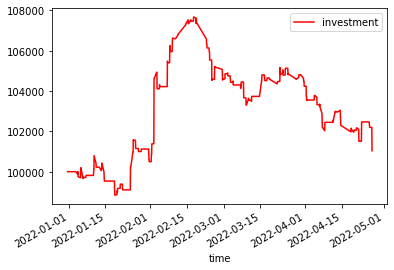

In [51]:
time1 = new_t
coln = ["time", "investment"]
ner = pd.DataFrame(columns = coln)
ner["time"] = time1
ner["investment"] = ne
ner.plot(x = "time", y = "investment", color="red")
plt.show()

In [67]:
nepp

[[Timestamp('2022-01-03 12:30:00-0500', tz='America/New_York'),
  Timestamp('2022-01-03 13:30:00-0500', tz='America/New_York'),
  -122.03981943081953],
 [Timestamp('2022-01-04 09:30:00-0500', tz='America/New_York'),
  Timestamp('2022-01-04 10:30:00-0500', tz='America/New_York'),
  127.17243591307306],
 [Timestamp('2022-01-04 10:30:00-0500', tz='America/New_York'),
  Timestamp('2022-01-04 11:30:00-0500', tz='America/New_York'),
  -115.30905525956405],
 [Timestamp('2022-01-04 12:30:00-0500', tz='America/New_York'),
  Timestamp('2022-01-04 14:30:00-0500', tz='America/New_York'),
  -142.05576064454272],
 [Timestamp('2022-01-04 14:30:00-0500', tz='America/New_York'),
  Timestamp('2022-01-04 15:30:00-0500', tz='America/New_York'),
  -46.05828491543798],
 [Timestamp('2022-01-05 09:30:00-0500', tz='America/New_York'),
  Timestamp('2022-01-05 12:30:00-0500', tz='America/New_York'),
  496.84972635442364],
 [Timestamp('2022-01-05 13:30:00-0500', tz='America/New_York'),
  Timestamp('2022-01-06 09:

In [69]:
colq = ["open", "close", "profit"]
nx = pd.DataFrame(nepp, columns=colq)

In [54]:
#nx.index = [time_range[i] for i in range(1, len(time_range)-3)]

In [56]:
#nx["previous"] = [time_range[i] for i in range(1, len(time_range)-3)]

In [71]:

nx["Return"] = [x/100000 for x in nx["profit"]]

In [72]:
nx.iloc[0:50, ]

,open,close,profit,Return
0,2022-01-03 12:30:00-05:00,2022-01-03 13:30:00-05:00,-122.039819,-0.001220
1,2022-01-04 09:30:00-05:00,2022-01-04 10:30:00-05:00,127.172436,0.001272
2,2022-01-04 10:30:00-05:00,2022-01-04 11:30:00-05:00,-115.309055,-0.001153
3,2022-01-04 12:30:00-05:00,2022-01-04 14:30:00-05:00,-142.055761,-0.001421
4,2022-01-04 14:30:00-05:00,2022-01-04 15:30:00-05:00,-46.058285,-0.000461
5,2022-01-05 09:30:00-05:00,2022-01-05 12:30:00-05:00,496.849726,0.004968
6,2022-01-05 13:30:00-05:00,2022-01-06 09:30:00-05:00,-537.084910,-0.005371
7,2022-01-06 09:30:00-05:00,2022-01-06 11:30:00-05:00,93.216239,0.000932
8,2022-01-06 12:30:00-05:00,2022-01-06 14:30:00-05:00,-57.057396,-0.000571
9,2022-01-06 14:30:00-05:00,2022-01-06 15:30:00-05:00,20.520344,0.000205


In [75]:
with pd.ExcelWriter("new_pairtrading.xlsx", mode="w", engine="openpyxl") as writer:
            final_data.to_excel(writer, sheet_name=da, index = False) 